## Import Dependencies

In [122]:
# data manipulation 
import pandas as pd
import numpy as np

# model tuning and metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

# models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


# visualization 
import seaborn as sns 
import matplotlib.pyplot as plt
from yellowbrick.model_selection import FeatureImportances
from xgboost import plot_importance


## Data Import, Splitting and Resampling

### Import

In [78]:
# read in cleaned df and split into feature/target sets
df = pd.read_pickle('final_df.pkl')
X = df.drop(columns='label')
y = df['label']

### Train/Test/Validation Splits

In [79]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77, stratify=y)

# split validation from train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=77, stratify=y_train)

### Resampling
Given the curated nature of the dataset, we have some obvious imbalance to address as our number of bot observations vastly outnumbers our real human data. An interesting situation, a skewed inverse of the "true" distribution, but potentially very beneficial to our classification.

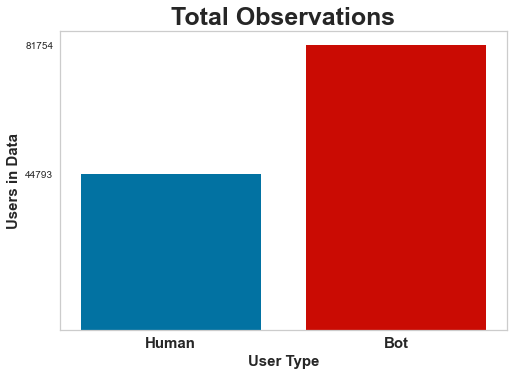

In [80]:
plt.bar([1,0], y.value_counts(), tick_label=['Bot', 'Human'], color=('r', 'b'),**{})
plt.title('Total Observations', fontsize=25, weight='bold')
plt.xlabel('User Type', fontsize=15, weight='bold')
plt.ylabel('Users in Data', fontsize=15, weight='bold')
plt.xticks(fontsize=15, weight='bold')
plt.yticks(ticks=[y.value_counts()[0], y.value_counts()[1]])
plt.grid(None)

We have a couple ways to approach this -- over or undersampling. Given the presence of strong outliers and the relatively large amount of overall data, we will likely fair as well or better with simple random resampling as with synthetic techniques. To over or undersample is a different question. Let's try both and compare.

In [81]:
# let's upsample the human training data
ros = RandomOverSampler(random_state=0)
rus = RandomUnderSampler(random_state=0)

X_train_ros, y_train_ros = ros.fit_sample(X_train,y_train)
X_train_rus, y_train_rus = rus.fit_sample(X_train,y_train)

We also have a significant amount of missing values in one column, **default_profile**, which seems like it may be a relatively important predictor. We'll go ahead an impute it. We can't apply basic imputation methods like mean imputation to this categorical data, so we'll opt for **KNN imputation**. 

KNN imputation will require us to scale our features as well. The large outliers in our data make mean and standard deviation poorly representative distribution metrics, so we'll use **RobustScaler **instead of StandardScaler since it will allow us to center on our IQR instead of mean. 

We'll combine this scaling and imputation into a single step completed outside of our modeling pipeline since model convergence will only gain from scaling and our imputation method is relatively expensive. 

It's important to note that we fit our scaler and imputer to our training data, and use those training set parameters on our validation and test sets to avoid data leakage.

In [82]:
# scaling and imputation steps -- we don't want these in a Pipeline because KNN imputation takes too long

def rob_sca_knn_imp(X_tr,X_te, X_va,k=3):
    # robust scaling, needed for KNN imputation
    scaler = RobustScaler().fit(X_tr)
    X_tr = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)
    X_te = pd.DataFrame(scaler.transform(X_te), columns=X_tr.columns)
    X_va = pd.DataFrame(scaler.transform(X_va), columns=X_tr.columns)

    # knn imputation for default_profile, roughly 9k missing values
    imputer = KNNImputer(n_neighbors=k).fit(X_tr)
    X_tr = pd.DataFrame(imputer.transform(X_tr), columns=X_tr.columns)
    X_te = pd.DataFrame(imputer.transform(X_te), columns=X_tr.columns)
    X_va = pd.DataFrame(imputer.transform(X_va), columns=X_tr.columns)

    return X_tr, X_te, X_va

In [83]:
X_train_ros, X_test_ros, X_val_ros = rob_sca_knn_imp(X_train_ros, X_test, X_val)
X_train_rus, X_test_rus, X_val_rus = rob_sca_knn_imp(X_train_rus, X_test, X_val)

### Model Pipelining

In [84]:
models = [LogisticRegression(C=1, max_iter=2000), 
            KNeighborsClassifier(n_neighbors=5),
            GaussianNB(),
            DecisionTreeClassifier(),
            RandomForestClassifier(random_state=51),
            XGBClassifier(random_state=51)]

In [85]:
def fit_models(X_tr, y_tr, models):
    fit_models = []
    for model in models:
        mod = model
        mod.fit(X_tr, y_tr)
        fit_models.append(mod)
    return fit_models

In [86]:
baseline_ros_models = fit_models(X_train_ros, y_train_ros, models)    
baseline_rus_models = fit_models(X_train_rus, y_train_rus, models)   

In [87]:
def score_models(X_tr,y_tr,X_va,y_va,models,fit=True):
    """
    (optionally) fit and score models on training and validation sets
    
    models -> list of models to score
    fit=True -> fit the models in the list to X_tr and y_tr before scoring
       =False -> models are already fit to X_tr, y_tr (for quickly scoring pre-fit models)
    """
    
    if fit: 
        mods = fit_models(X_tr, y_tr, X_va, y_va, models)
    else: 
        mods = models

    # score each model on train and val and append to scores    
    score_table = []
    for model in mods:    
        preds_tr = model.predict(X_tr)
        preds_va = model.predict(X_va)
        scores = [f1_score(y_tr, preds_tr), 
                  f1_score(y_va, preds_va), 
                  precision_score(y_tr, preds_tr), 
                  precision_score(y_va, preds_va), 
                  recall_score(y_tr, preds_tr), 
                  recall_score(y_va, preds_va)]
        score_table.append(scores)

    # convert scores to df and return with model names as index
    score_df = pd.DataFrame(score_table, columns=['TrainF1', 'ValF1', 'TrainAcc', 'ValAcc', 'TrainRec', 'ValRec'])
    score_df['Model'] = ['LogReg', 'KNN', 'GaussNB', 'DecTree', 'RandFor', 'XGB']   

    return score_df.set_index('Model')


In [88]:
baselines_ros_scores = score_models(X_train_ros, y_train_ros, X_val_ros, y_val, baseline_ros_models, fit=False)
baselines_rus_scores = score_models(X_train_rus, y_train_rus, X_val_rus, y_val, baseline_rus_models, fit=False)

In [89]:
baselines_ros_scores

,TrainF1,ValF1,TrainAcc,ValAcc,TrainRec,ValRec
Model,,,,,,
LogReg,0.858594,0.897029,0.817182,0.889530,0.904428,0.904654
KNN,0.947966,0.948073,0.955077,0.964915,0.940961,0.931808
GaussNB,0.777973,0.861677,0.641632,0.764060,0.987890,0.987891
DecTree,0.972970,0.949225,0.982599,0.962411,0.963529,0.936395
RandFor,0.981108,0.962654,0.993232,0.981751,0.969278,0.944285
XGB,0.966265,0.963090,0.977791,0.980483,0.955007,0.946303


In [90]:
baselines_rus_scores

,TrainF1,ValF1,TrainAcc,ValAcc,TrainRec,ValRec
Model,,,,,,
LogReg,0.859305,0.896142,0.818791,0.888969,0.904037,0.903431
KNN,0.951843,0.949139,0.953852,0.965223,0.949842,0.933582
GaussNB,0.778585,0.861693,0.642144,0.764121,0.988651,0.987829
DecTree,0.999851,0.948836,0.999851,0.961741,0.999851,0.936273
RandFor,0.999814,0.962436,0.999851,0.982358,0.999777,0.943306
XGB,0.974207,0.963007,0.982333,0.980968,0.966214,0.945691


#### Model Performance
* The tree-based models appear to dominate our baselines, though KNN isn't vastly outperformed.
* XGBoost seems to be midly outperformed on undersampled training predictions, but is more consistent in validation.
* These baseline models are entirely untuned, so greater performance differences may emerge as we adjust our hyperparameters.

#### Sampling Differences
* Decision Trees perform slightly better with undersampling.
* Random Forest performs better on undersampled training, but better on validation scaled and imputed on oversampled parameters.
* XGBoost is a mixed bag, performing marginally better on F1 when oversampled, but differences are all in the 0.2%-0.5% range and inconsistent across metrics and data set.

#### Initial Conclusion
* Given the solid baseline performance of the tree based models, let's move forward with the three of them as we head into optimization. As far as our sampling decision, the differences we see are marginal and vary with model, so we'll focus on undersampled data for the advantage to computation time. 



In [91]:
ros_lr, ros_knn, ros_nb, ros_tree, ros_rf, ros_xgb = tuple(baseline_ros_models)
rus_lr, rus_knn, rus_nb, rus_tree, rus_rf, rus_xgb = tuple(baseline_rus_models)

### Model Optimization

Since our dataset is relatively large and our models can get expensive, let's try introducing some additional features before tackling hyperparameter tuning. 

Let's start by taking a look at the feature importance charts for our current models. 

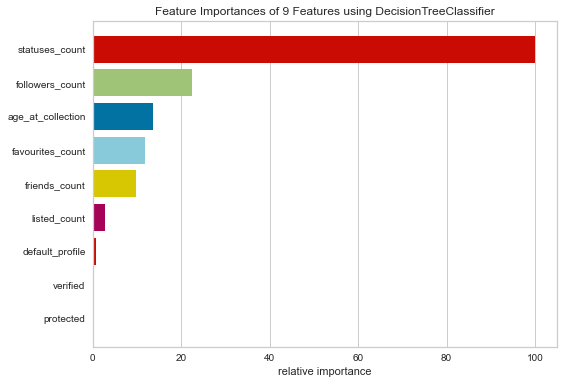

In [92]:
tree_viz = FeatureImportances(DecisionTreeClassifier())
tree_viz.fit(X_train_rus, y_train_rus)
tree_viz.show()

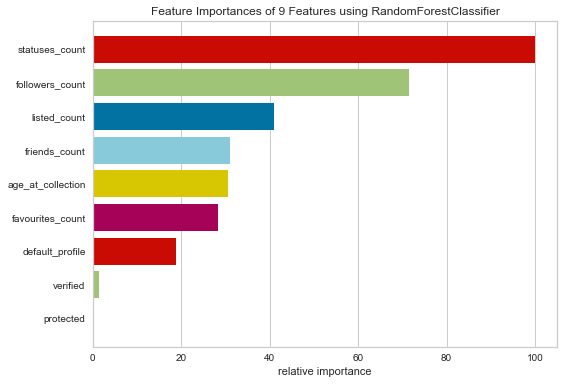

In [93]:
rf_viz = FeatureImportances(RandomForestClassifier())
rf_viz.fit(X_train_rus, y_train_rus)
rf_viz.show()


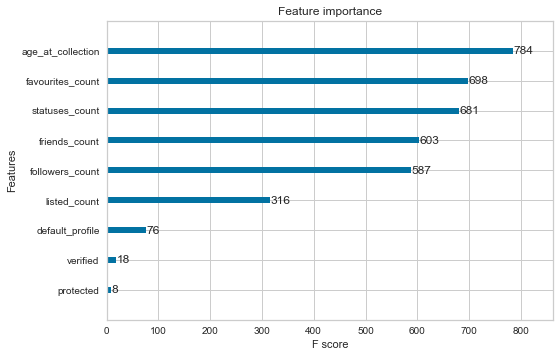

In [94]:
plot_importance(rus_xgb)

#### Observations
Very interesting. Each of these models achieved a similar scores in the 95% range, but appear to have valued very different features in order to get there. 
* The basic Decision Tree is especially interesting, managing to achieve comparable scores to the ensemble and boosted methods while being *dominated* by a single feature: **status_counts**, which appears to be roughly as influential as every other feature combined.
* Random Forests is a bit more balanced, but driven strongly by *status_count* and *follower_count*. Surprisingly, listed_count was relatively important in the model, despite the relative sparsity of listed users.
* XGBoost possesses the most balanced feature importance, and seems relatively consistent with intuition. Account age was the driving feature here, substantially more important in the boosted model than in our other candidates. The 'social' categories (favorites, statuses, 'friends' and followers) are weighted relatively equally, and following them is a noticable drop in feature importance as we arrive at the less populous observations of listed_count, default_profile, and verified and protected account statuses. 

#### Takeaways
* The models took very different approaches to arrive at similar conclusions. Using feature importance as an insight into their methods, XGBoost may prove a more easily interpretable and generalizable candidate in the long run. While the other two models perform just as well on our curated data set, their reliance on top-heavy features may prove to create challenges when attempting to classify more realistic sets of observations. By the same token, though, XGBoost may be overfitting to features which are overrepresented by our data.
* 
* With this in mind, let's forget decision trees and focus on optimizing our random forest and XGBoost models.


Let's introduct some new features -- we'll start with some additional booleans to represent the excessive 0 values in many of our categories.

In [95]:
X2 = X.copy()
y2 = y.copy()

# add 'zero' features
X2['zero_favourites'] = (X2['favourites_count']==0).astype(float)
X2['zero_statuses'] = (X2['statuses_count']==0).astype(float)
X2['zero_friends'] = (X2['friends_count']==0).astype(float)
X2['zero_followers'] = (X2['followers_count']==0).astype(float)
X2['zero_listed'] = (X2['listed_count']==0).astype(float)

In [96]:
# train, test, split with same random state
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=77, stratify=y2)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train, y2_train, test_size=0.25, random_state=77, stratify=y2_train)

In [97]:
# resample with same random state
X2_train_rus, y2_train_rus = rus.fit_sample(X2_train, y2_train)

In [98]:
# re-scale and re-impute
# Note: this will be the first major divergence from the original data since imputation will occur with 5 new features
X2_train_rus, X2_test_rus, X2_val_rus = rob_sca_knn_imp(X2_train_rus, X2_test, X2_val)


In [99]:
# fit the naive models, we'll look at all of them just to get a sense of the new features impact
X2_rus_models = fit_models(X2_train_rus, y2_train_rus, models)

In [100]:
X2_rus_scores = score_models(X2_train_rus, y2_train_rus, X2_val_rus, y2_val, X2_rus_models, fit=False)

In [101]:
X2_rus_scores

,TrainF1,ValF1,TrainAcc,ValAcc,TrainRec,ValRec
Model,,,,,,
LogReg,0.883742,0.909204,0.878141,0.929082,0.889414,0.890160
KNN,0.953243,0.951949,0.956745,0.967832,0.949767,0.936579
GaussNB,0.864494,0.912759,0.782811,0.867500,0.965209,0.962999
DecTree,0.999851,0.949046,0.999851,0.962690,0.999851,0.935784
RandFor,0.999851,0.960891,0.999851,0.981196,0.999851,0.941410
XGB,0.975001,0.964087,0.983641,0.982354,0.966512,0.946486


In [102]:
baselines_rus_scores

,TrainF1,ValF1,TrainAcc,ValAcc,TrainRec,ValRec
Model,,,,,,
LogReg,0.859305,0.896142,0.818791,0.888969,0.904037,0.903431
KNN,0.951843,0.949139,0.953852,0.965223,0.949842,0.933582
GaussNB,0.778585,0.861693,0.642144,0.764121,0.988651,0.987829
DecTree,0.999851,0.948836,0.999851,0.961741,0.999851,0.936273
RandFor,0.999814,0.962436,0.999851,0.982358,0.999777,0.943306
XGB,0.974207,0.963007,0.982333,0.980968,0.966214,0.945691


The additional features haven't drastically impacted our target models. However, they noticeably improve the performance of our baseline logistic regression and naive bayes (NB saw an 11% jump in training F1, with 14% more accuracy at the cost of 2% of recall). We see very mild performance drops for KNN and our Decision Tree and Random Forest models but XGBoost had improvements across the board. Given that our simplest and most interpretable models significantly benefitted from the inclusion of these features, we can consider keeping them.  

Let's see how the models treated these new features to be sure. 

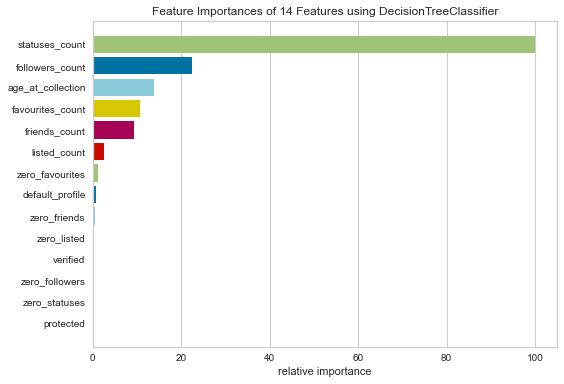

In [103]:
X2_tree_viz = FeatureImportances(DecisionTreeClassifier())
X2_tree_viz.fit(X2_train_rus, y2_train_rus)
X2_tree_viz.show()

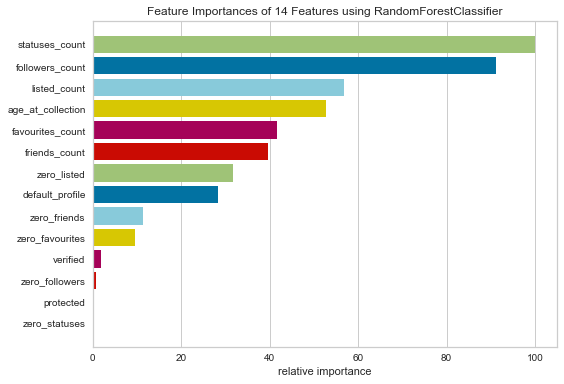

In [104]:
X2_rf_viz = FeatureImportances(RandomForestClassifier())
X2_rf_viz.fit(X2_train_rus, y2_train_rus)
X2_rf_viz.show()

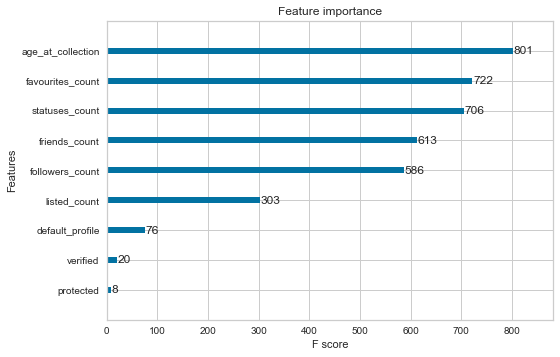

In [105]:
plot_importance(X2_rus_models[-1])

Interesting, our XGBoost model was the only one that didn't suffer from the new features -- but it seems that's because it didn't use them at all! The slight performance gain we saw, and the slightly different importance values may reflect the change in imputed default_profile values, or the new feature layout leading to a lucky efficiency gain during fitting.

Random Forests actually made use of the new features, but ultimately suffered in performance as a result. It could potentially be more robust with the moderately more balanced feature importances, but the gains appear minimal. 

In either case, if our target models won't be making real use of these features, there's no reason to increase the size of our data by over 50%. Let's move on without them.

I suspect many bots may be generated using combinations of common names/numbers. Let's try to detect whether or not a particular username is 'generic' -- we'll need to do a bit of legwork to get this going.

In [106]:
# generate list of firstname/lastname

first_names = pd.read_csv('firstnames.csv')['FirstName'].apply(lambda x: x.lower())
last_names = pd.read_csv('lastnames.csv')['LastName'].apply(lambda x: x.lower())
# first_last = first_names['FirstName'] + last_names['LastName']

first_last = []
for first in first_names:
    for last in last_names:
        first_last.append(first + last)
        first_last.append(last + first)

names = set(first_last + list(first_names) + list(last_names))



# last_first= last_names + first_names
# last_first


In [107]:
# read in a version of our df with screen name as a feature
sn_df = pd.read_pickle('screen_name_final_df.pkl')


In [108]:
# split names and numbers and store vars
import re

def split_name(name):
    # regex split on numbers, get text and number strings in name, filter out empty strings from the split return     
    return list(filter(None, re.split(r'(\d+)', name)))

generic = []
for name in sn_df['screen_name']:
    all_generic = 0
    has_name = False
    for word in split_name(name):
        if word.isalpha():
            # if it contains a word that's not a common name, it's not generic
            if word not in names:
                break
            # if we see a name in part of the screen_name, mark it and keep looking
            else: 
                has_name = True
        # if we have a name and there's no non-name word, it's generic
        if has_name:
            all_generic = 1 
        # 
    generic.append(all_generic)
sn_df['generic'] = generic

In [109]:
sn_df.groupby('label')['generic'].sum()

label
0.0     64
1.0    696
Name: generic, dtype: int64

It seems that even this extremely simple definition of 'generic' names garners us some interesting information. Though our data ratio is roughly 2-1 bots to humans, the ratio of generically named bots to humans is over 10-1. Our definition is clearly limited by our 'top 100 American' data source and 'name/number' schema assumption, but future expansion to a more exhaustive global set of names and name formats could provide a powerful predictive metric.
We don't have a whole lot of positive observations (<1% overall) so our model may not be greatly impacted by including this feature as-is. But let's fit it and see if we achieve minor gains.

In [116]:
X_sn = sn_df.drop(columns=['label', 'screen_name'])
y_sn = sn_df['label']

# split train and test
X_sn_train, X_sn_test, y_sn_train, y_sn_test = train_test_split(X_sn, y_sn, test_size=0.2, random_state=77, stratify=y_sn)

# split validation from train
X_sn_train, X_sn_val, y_sn_train, y_sn_val = train_test_split(X_sn_train, y_sn_train, test_size=0.25, random_state=77, stratify=y_sn_train)

# resample
X_sn_train_rus, y_sn_train_rus = rus.fit_sample(X_sn_train, y_sn_train)

# scale and impute
X_sn_train_rus, X_sn_test_rus, X_sn_val_rus = rob_sca_knn_imp(X_sn_train_rus, X_sn_test, X_sn_val)




In [117]:
X_sn_rus_models = fit_models(X_sn_train_rus, y_sn_train_rus, models)
X_sn_rus_scores = score_models(X_sn_train_rus, y_sn_train_rus, X_sn_val_rus, y_sn_val, X_sn_rus_models, fit=False)

In [118]:
X_sn_rus_scores

,TrainF1,ValF1,TrainAcc,ValAcc,TrainRec,ValRec
Model,,,,,,
LogReg,0.859411,0.896108,0.818893,0.888962,0.904149,0.903370
KNN,0.951792,0.949047,0.953712,0.965099,0.949879,0.933521
GaussNB,0.780804,0.862840,0.645311,0.766407,0.988316,0.987034
DecTree,0.999851,0.948338,0.999851,0.962464,0.999851,0.934622
RandFor,0.999814,0.962051,0.999814,0.981423,0.999814,0.943429
XGB,0.975367,0.963302,0.984386,0.980857,0.966512,0.946364


In [113]:
baselines_rus_scores

,TrainF1,ValF1,TrainAcc,ValAcc,TrainRec,ValRec
Model,,,,,,
LogReg,0.859305,0.896142,0.818791,0.888969,0.904037,0.903431
KNN,0.951843,0.949139,0.953852,0.965223,0.949842,0.933582
GaussNB,0.778585,0.861693,0.642144,0.764121,0.988651,0.987829
DecTree,0.999851,0.948836,0.999851,0.961741,0.999851,0.936273
RandFor,0.999814,0.962436,0.999851,0.982358,0.999777,0.943306
XGB,0.974207,0.963007,0.982333,0.980968,0.966214,0.945691


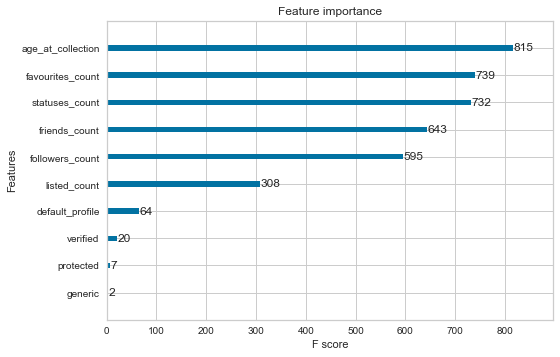

In [119]:
plot_importance(X_sn_rus_models[-1])

The additional feature slightly hurt our F1 performance on Decision Trees and Random Forests, but benefitted our boosted model and the feature importance reveals it was actually used (albeit minimally) unlike the 'zero' features. Given the relatively small amount of generic names in the dataset, the small validation split likely contains very few, but the usefulness of this feature may increase as we scale to larger sets, so we'll keep it.

Now that we're relatively confident in our feature set and target models, let's use GridSearch to see if we can squeeze any more performance out of these models. 

In [121]:
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [128]:
# use these results to focus tuning further

rf = RandomForestClassifier(random_state=51)
rf_param_grid = {'n_estimators':[100,500,1000],
                 'bootstrap':[True, False],
                 'max_depth':[3, 5, 10, 20, 50, 75, 100, None],
                 'max_features':['auto', 'sqrt'],
                 'min_samples_leaf':[1,2,4,10],
                 'min_samples_split':[2,5,10]}
clf_rf_rnd = RandomizedSearchCV(rf, param_distributions=rf_param_grid, n_iter=100, cv=5, verbose=True, n_jobs=-1, scoring='f1')
best_clf_rf_rnd = clf_rf_rnd.fit(X_sn_train_rus, y_sn_train_rus)
clf_performance(best_clf_rf_rnd, 'Random Forest')



Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [ ]:
xgb = XGBClassifier(random_state=51)
xgb_param_grid = {'n_estimators':[20,50,100,250,500,1000],
                  'colsample_bytree':[0.2,0.5,0.7,0.8,1],
                  'max_depth':[2,5,10,15,20,25,None],
                  'reg_alpha':[0,0.5,1],
                  'reg_lambda':[1,1.5,2],
                  'subsample':[0.5,0.6,0.7,0.8,0.9],
                  'learning_rate':[.01,0.1,0.2,0.3,0.5,0.7,0.9],
                  'gamma':[0,.01,.1,1,10,100],
                  'min_child_weight':[0,.01,0.1,1,10,100],
                  'sampling_method':['uniform','gradient_based']}
clf_xgb_rnd = RandomizedSearchCV(xgb, param_distributions=xgb_param_grid, n_iter=1000, cv=5, verbose=True, n_jobs=-1, scoring='f1')
best_clf_xgb_rnd = clf_xgb_rnd.fit(X_sn_train_rus, y_sn_train_rus)
clf_performance(best_clf_xgb_rnd, 'XGB')